In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # GPU / CPU 선택

#### Input으로 입력할 때 Normalize하는 이유

데이터 분포를 고르게하여 Local Optimum에 빠져나와 최적해에 빠르게 수렴하기 위해

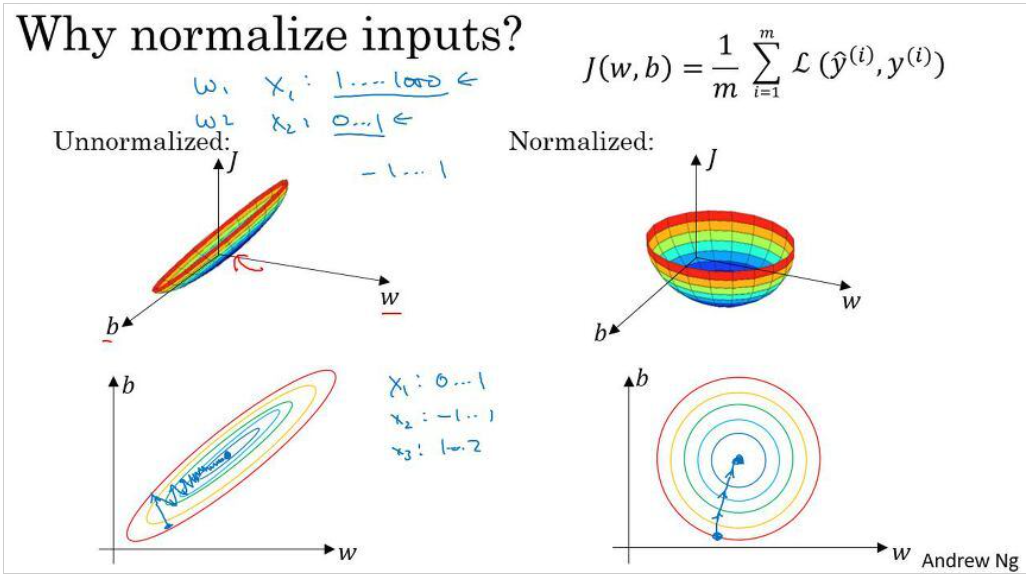


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # numpy.array [0, 255] -> Torch.FloatTensor [0.0, 1.0]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # ((channel 별 평균), (channel 별 표준편차))로 정규화
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
pre_model = torchvision.models.resnet18(pretrained=True)
print(pre_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Weight 고정을 위해 상수 처리 (requires_grad = False : update X)

CIFAR-10은 10개의 클래스로 분류하므로 마지막 Linear layer의 output features를 1000에서 10으로 변경

In [7]:
for param in pre_model.parameters():
  param.requires_grad = False

pre_model.fc = nn.Linear(pre_model.fc.in_features, 10)
pre_model = pre_model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pre_model.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler

In [10]:
def train_model(model, criterion, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)

        #model.train()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)  # loss value * batch size
            # preds == labels : tensor([Fale, False, True, True])  # 배치마다 정답 레이블과 비교
            # torch.sum(preds == labels) : tensor(2)  # 맞춘 개수
            running_corrects += torch.sum(preds == labels)  #

        epoch_loss = running_loss / len(trainset)  # len(trainset) : 50000
        epoch_acc = running_corrects.double() / len(trainset)

        print(f'Loss {epoch_loss:.4f} Acc:{epoch_acc:.4f}')
        print()

    return model


In [11]:
pre_model = train_model(pre_model, criterion, optimizer, num_epochs=2)

Epoch 1/2
----------
Loss 2.5971 Acc:0.2589

Epoch 2/2
----------
Loss 2.6142 Acc:0.2631



Transfer Learning의 경우 사전학습된 모델의 weight가 유의미하다고 여기기 때문에 learning rate를 작게 해애됨(또는 lr schedule 적용)

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = pre_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 27 %
